### Objetivo:
O objetivo desse projeto é aprensetar o histórico de temperatura de 1996-2020 e tentar prever a temperatura dos próximos 2 anos (2021, 2022) de 3 cidades brasileiras:
    
    Rio de Janeiro
    São Paulo
    Brasília


### Bibliotecas utilizadas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import datetime
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


### Visualização e tratamento dos dados

In [2]:
dados = pd.read_csv('city_temperature.csv')

In [3]:
dados.head()


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [4]:
print('O DataFrame possui {} linhas e {} colunas'.format(dados.shape[0], dados.shape[1]))

O DataFrame possui 2906327 linhas e 8 colunas


In [5]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int64  
 5   Day             int64  
 6   Year            int64  
 7   AvgTemperature  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 177.4+ MB


In [6]:
dados.isnull().sum()

Region                  0
Country                 0
State             1450990
City                    0
Month                   0
Day                     0
Year                    0
AvgTemperature          0
dtype: int64

In [7]:
dados.Day.min()

0

In [8]:
#excluindo a coluna state
del dados['State']

In [9]:
#excluindo os dados com o dia do mês = 0
dia_0 = dados[dados.Day == 0]
dia_0

,Region,Country,City,Month,Day,Year,AvgTemperature
82774,Africa,Guinea,Conakry,3,0,2008,-99.0
85697,Africa,Guinea,Conakry,3,0,2016,-99.0
92041,Africa,Guinea-Bissau,Bissau,3,0,2008,-99.0
146077,Africa,Malawi,Lilongwe,3,0,2012,-99.0
177862,Africa,Nigeria,Lagos,3,0,2008,-99.0
241159,Africa,Uganda,Kampala,3,0,2012,-99.0
1209901,North America,Mexico,Guadalajara,3,0,2012,-99.0
1333910,South/Central America & Carribean,Cuba,Havana,3,0,2008,-99.0


In [10]:
dados = dados.drop(index = dia_0.index)

In [11]:
dados.Year.min()

200

In [12]:
dados.Year.value_counts()

2000    119682
1999    119355
2001    119355
2002    119355
2003    119140
1998    119082
1996    118951
1997    118656
2004    118645
1995    118616
2005    117895
2006    117647
2010    115627
2007    115428
2008    114904
2009    114247
2011    113740
2012    111990
2013    111021
2014    109018
2015    107498
2016    107236
2017    106946
2018    106698
2019    106337
2020     38810
201        351
200         89
Name: Year, dtype: int64

In [13]:
#excluindo os anos 201 e 200
ano_erro = dados[(dados['Year'] == 200) | (dados['Year'] == 201)]
print(ano_erro.shape[0])
dados = dados.drop(index = ano_erro.index)


440


In [14]:
dados.shape[0]

2905879

In [15]:
print(dados.Day.min())
print(dados.Day.max())

1
31


In [16]:
#criando uma coluna de data com o ano, mes e dia - formato americano
datas=["Year","Month","Day"]
dados['Date'] = dados[datas].apply(lambda x: '-'.join(x.values.astype(str)), axis=1)

In [17]:
dados['Date'] = pd.to_datetime(dados['Date'])

In [18]:
#transformando a temperatura em Celcius
dados['TempCelcius'] = round((dados['AvgTemperature'] - 32) / 1.8,2)


In [19]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2905879 entries, 0 to 2906326
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Region          object        
 1   Country         object        
 2   City            object        
 3   Month           int64         
 4   Day             int64         
 5   Year            int64         
 6   AvgTemperature  float64       
 7   Date            datetime64[ns]
 8   TempCelcius     float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 221.7+ MB


In [20]:
dados.head()

,Region,Country,City,Month,Day,Year,AvgTemperature,Date,TempCelcius
0,Africa,Algeria,Algiers,1,1,1995,64.2,1995-01-01,17.89
1,Africa,Algeria,Algiers,1,2,1995,49.4,1995-01-02,9.67
2,Africa,Algeria,Algiers,1,3,1995,48.8,1995-01-03,9.33
3,Africa,Algeria,Algiers,1,4,1995,46.4,1995-01-04,8.00
4,Africa,Algeria,Algiers,1,5,1995,47.9,1995-01-05,8.83


In [21]:
dados.Region.value_counts()

North America                        1556651
Europe                                381695
Asia                                  316663
Africa                                250996
South/Central America & Carribean     219529
Middle East                           124749
Australia/South Pacific                55596
Name: Region, dtype: int64

In [22]:
dados.Country.value_counts()

US                   1455337
Canada                 74245
Australia              46330
China                  46329
India                  37063
                      ...   
Guyana                  5065
Israel                  4641
Burundi                 4543
Georgia                 4378
Serbia-Montenegro       3427
Name: Country, Length: 125, dtype: int64

In [23]:
#selecionando os dados somente da América Central e América do Sul
america_centro_sul = dados['Region'] == 'South/Central America & Carribean'
n1 = dados[america_centro_sul].shape[0]
n1

219529

In [24]:
n1 = dados[america_centro_sul]
n1

,Region,Country,City,Month,Day,Year,AvgTemperature,Date,TempCelcius
1231460,South/Central America & Carribean,Argentina,Buenos Aires,1,1,1995,82.4,1995-01-01,28.00
1231461,South/Central America & Carribean,Argentina,Buenos Aires,1,2,1995,75.1,1995-01-02,23.94
1231462,South/Central America & Carribean,Argentina,Buenos Aires,1,3,1995,73.7,1995-01-03,23.17
1231463,South/Central America & Carribean,Argentina,Buenos Aires,1,4,1995,77.1,1995-01-04,25.06
1231464,South/Central America & Carribean,Argentina,Buenos Aires,1,5,1995,79.5,1995-01-05,26.39
...,...,...,...,...,...,...,...,...,...
1450985,South/Central America & Carribean,Venezuela,Caracas,5,8,2020,80.5,2020-05-08,26.94
1450986,South/Central America & Carribean,Venezuela,Caracas,5,9,2020,81.3,2020-05-09,27.39
1450987,South/Central America & Carribean,Venezuela,Caracas,5,10,2020,80.2,2020-05-10,26.78
1450988,South/Central America & Carribean,Venezuela,Caracas,5,11,2020,81.1,2020-05-11,27.28


In [25]:
print(n1.Country.unique())

['Argentina' 'Bahamas' 'Bermuda' 'Belize' 'Bolivia' 'Barbados' 'Brazil'
 'Colombia' 'Costa Rica' 'Cuba' 'Dominican Republic' 'Equador' 'Guatemala'
 'Guyana' 'Haiti' 'Honduras' 'Nicaragua' 'Panama' 'Peru' 'Suriname'
 'Uruguay' 'Venezuela']


In [26]:
print(n1.Country.value_counts())

Brazil                27797
Equador               16556
Suriname               9268
Haiti                  9268
Costa Rica             9266
Uruguay                9266
Panama                 9266
Guatemala              9266
Argentina              9266
Colombia               9266
Bolivia                9266
Dominican Republic     9265
Bahamas                9265
Honduras               9265
Venezuela              9265
Cuba                   9263
Belize                 9263
Nicaragua              9245
Barbados               8542
Peru                   7627
Bermuda                5713
Guyana                 5065
Name: Country, dtype: int64


In [27]:
#visualizando o Brasil
brasil = dados['Country'] == 'Brazil'
n2 = dados[brasil]
n2

,Region,Country,City,Month,Day,Year,AvgTemperature,Date,TempCelcius
1282775,South/Central America & Carribean,Brazil,Brasilia,1,1,1995,70.9,1995-01-01,21.61
1282776,South/Central America & Carribean,Brazil,Brasilia,1,2,1995,71.7,1995-01-02,22.06
1282777,South/Central America & Carribean,Brazil,Brasilia,1,3,1995,71.2,1995-01-03,21.78
1282778,South/Central America & Carribean,Brazil,Brasilia,1,4,1995,69.2,1995-01-04,20.67
1282779,South/Central America & Carribean,Brazil,Brasilia,1,5,1995,68.5,1995-01-05,20.28
...,...,...,...,...,...,...,...,...,...
1310567,South/Central America & Carribean,Brazil,Sao Paulo,5,9,2020,61.7,2020-05-09,16.50
1310568,South/Central America & Carribean,Brazil,Sao Paulo,5,10,2020,63.7,2020-05-10,17.61
1310569,South/Central America & Carribean,Brazil,Sao Paulo,5,11,2020,65.9,2020-05-11,18.83
1310570,South/Central America & Carribean,Brazil,Sao Paulo,5,12,2020,66.8,2020-05-12,19.33


In [28]:
n2.City.unique()

array(['Brasilia', 'Rio de Janeiro', 'Sao Paulo'], dtype=object)

In [29]:
#excluindo as temperaturas com erro
n2.TempCelcius.value_counts()

-72.78    301
 22.00    243
 21.50    243
 22.56    237
 22.28    233
         ... 
 32.11      1
 32.39      1
 32.22      1
 33.00      1
 9.67       1
Name: TempCelcius, Length: 408, dtype: int64

In [30]:
n2_erro = n2[n2.TempCelcius == -72.78]

In [31]:
#excluindo a temperatura negativa
n2 = n2.drop(index = n2_erro.index)

In [32]:
#visualizando o Rio de Janeiro
rio = n2['City'] == 'Rio de Janeiro'
n3 = n2[rio]
n3

,Region,Country,City,Month,Day,Year,AvgTemperature,Date,TempCelcius
1292041,South/Central America & Carribean,Brazil,Rio de Janeiro,1,1,1995,84.7,1995-01-01,29.28
1292042,South/Central America & Carribean,Brazil,Rio de Janeiro,1,2,1995,83.5,1995-01-02,28.61
1292043,South/Central America & Carribean,Brazil,Rio de Janeiro,1,3,1995,83.5,1995-01-03,28.61
1292044,South/Central America & Carribean,Brazil,Rio de Janeiro,1,4,1995,83.5,1995-01-04,28.61
1292045,South/Central America & Carribean,Brazil,Rio de Janeiro,1,5,1995,84.7,1995-01-05,29.28
...,...,...,...,...,...,...,...,...,...
1301301,South/Central America & Carribean,Brazil,Rio de Janeiro,5,8,2020,69.5,2020-05-08,20.83
1301302,South/Central America & Carribean,Brazil,Rio de Janeiro,5,9,2020,70.3,2020-05-09,21.28
1301303,South/Central America & Carribean,Brazil,Rio de Janeiro,5,10,2020,72.2,2020-05-10,22.33
1301304,South/Central America & Carribean,Brazil,Rio de Janeiro,5,11,2020,73.1,2020-05-11,22.83


In [33]:
n3.TempCelcius.max()

34.11

In [34]:
n3.TempCelcius.min()

15.56

In [35]:
sampa = n2['City'] == 'Sao Paulo'
n4 = n2[sampa]

In [36]:
brasilia = n2['City'] == 'Brasilia'
n5 = n2[brasilia]

### Visualização gráfica das temperaturas nas cidades brasileiras

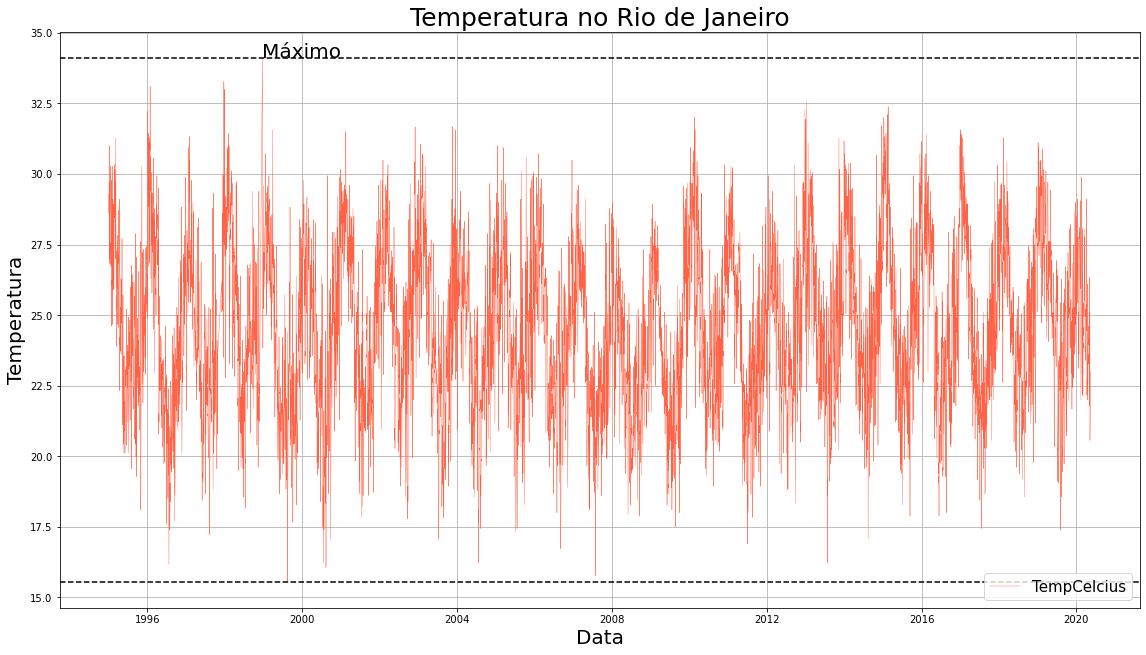

In [37]:
#Rio de Janeiro com os pontos de máximo e mínimo
fig = plt.figure(figsize=(15,8))
eixo = fig.add_axes([0, 0, 1, 1])
eixo.plot(n3['Date'], n3['TempCelcius'], color = 'tomato', lw = 0.4)

eixo.set_title('Temperatura no Rio de Janeiro', fontsize=25)
eixo.set_ylabel('Temperatura', fontsize=20)
eixo.set_xlabel('Data', fontsize=20)
eixo.legend(['TempCelcius'], loc ='lower right', fontsize=15)
eixo.grid(True)

x1 = n3['Date'][n3['TempCelcius'].idxmax()]
y1 = max(n3['TempCelcius'])

eixo.annotate('Máximo', xy=(x1,y1), fontsize = 20)

              
eixo.axhline(max(n3['TempCelcius']), color = 'k', linestyle='--')
eixo.axhline(min(n3['TempCelcius']), color = 'k', linestyle='--')

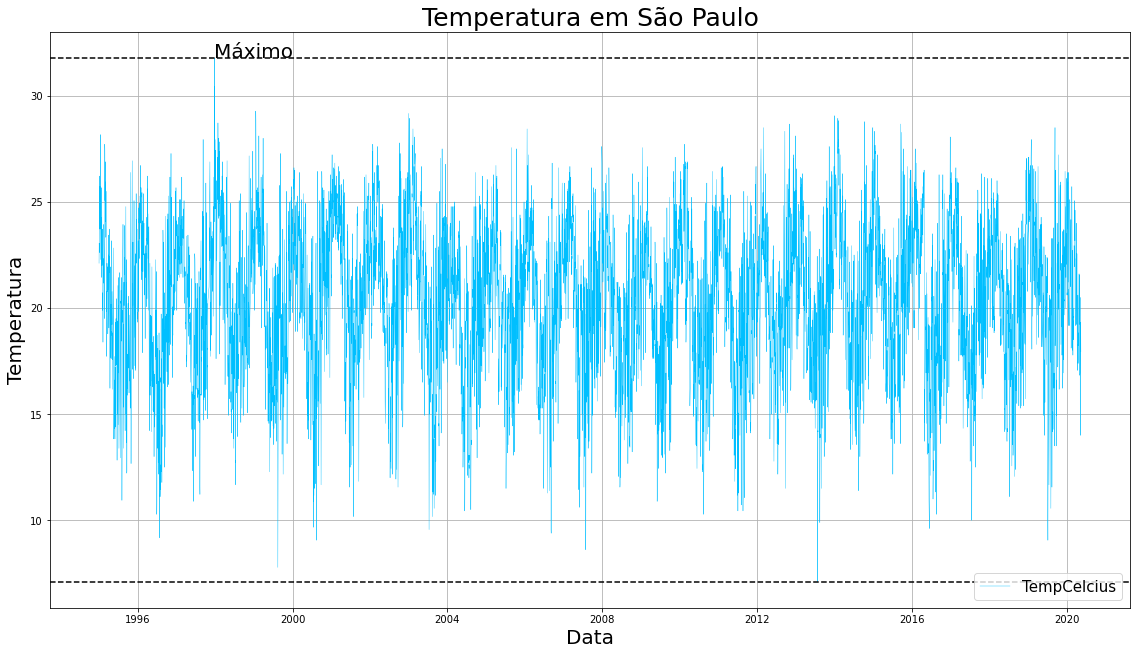

In [38]:
#São Paulo
fig = plt.figure(figsize=(15,8))
eixo = fig.add_axes([0, 0, 1, 1])
eixo.plot(n4['Date'], n4['TempCelcius'], color = 'deepskyblue', lw = 0.4)

eixo.set_title('Temperatura em São Paulo', fontsize=25)
eixo.set_ylabel('Temperatura', fontsize=20)
eixo.set_xlabel('Data', fontsize=20)
eixo.legend(['TempCelcius'], loc ='lower right', fontsize=15)
eixo.grid(True)

x1 = n4['Date'][n4['TempCelcius'].idxmax()]
y1 = max(n4['TempCelcius'])

eixo.annotate('Máximo', xy=(x1,y1), fontsize = 20)

              
eixo.axhline(max(n4['TempCelcius']), color = 'k', linestyle='--')
eixo.axhline(min(n4['TempCelcius']), color = 'k', linestyle='--')

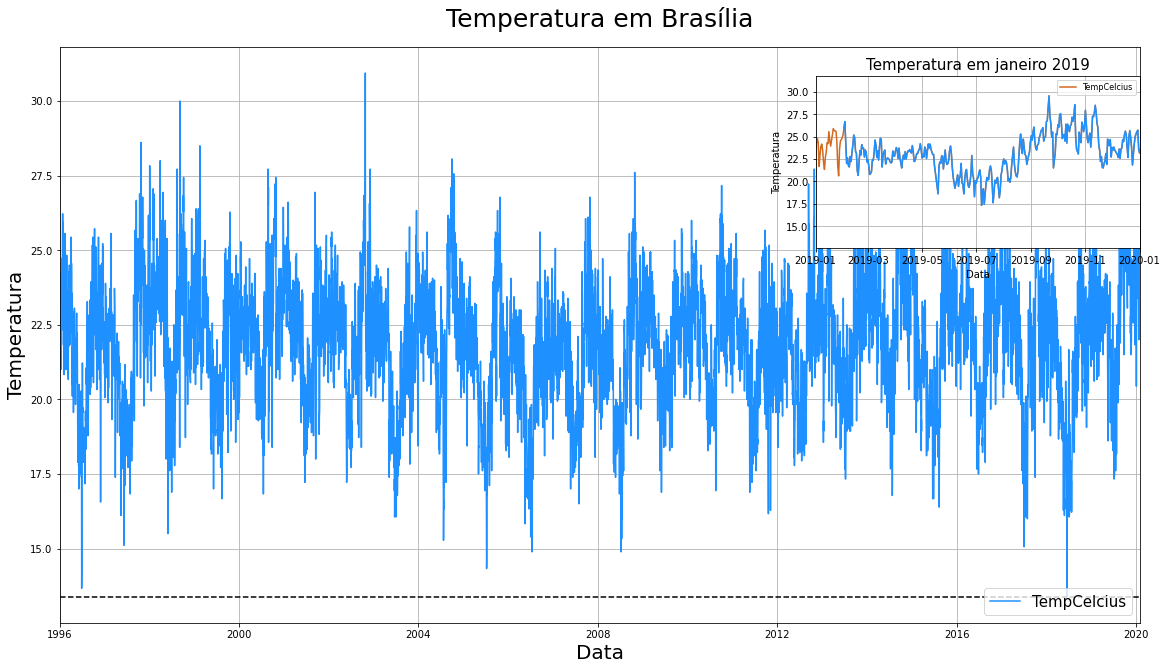

In [39]:
#Em Brasília vamos analisar a Temperatura em 2019
fig = plt.figure(figsize=(15,8))

eixo = fig.add_axes([0,0,1,1])
eixo2 = fig.add_axes([0.7,0.65,0.3,0.3])
eixo.grid(True)
eixo.plot(n5['Date'], n5['TempCelcius'], color ='dodgerblue')
eixo.set_xlim(datetime.datetime(1996,1,1), datetime.datetime(2020,1,31))
eixo.set_title('Temperatura em Brasília', fontsize = 25, pad=20)
eixo.legend(['TempCelcius'], loc='lower right', fontsize = 15)
eixo.set_ylabel('Temperatura', fontsize=20)
eixo.set_xlabel('Data', fontsize=20)

esquerda = n5['Date'] < datetime.datetime(2019,1,1)
direita = n5['Date'] > datetime.datetime(2019,2,1)

eixo2.plot(n5['Date'], n5['TempCelcius'], color='chocolate')
eixo2.plot(n5[esquerda]['Date'],n5[esquerda]['TempCelcius'], color = 'dodgerblue')
eixo2.plot(n5[direita]['Date'],n5[direita]['TempCelcius'], color = 'dodgerblue')
eixo2.set_xlim(datetime.datetime(2019,1,1), datetime.datetime(2020,1,1))
eixo2.set_title('Temperatura em janeiro 2019', fontsize = 15)
eixo2.legend(['TempCelcius'], loc='best', fontsize = 8)
eixo2.set_ylabel('Temperatura', fontsize=10)
eixo2.set_xlabel('Data', fontsize=10)
eixo2.grid(True)

eixo.axhline(min(n5['TempCelcius']), color = 'k', linestyle='--')


# Prevendo a temperatura das cidades Brasileiras com o Prophet

### Prophet
A biblioteca utilizada será a Prophet, que faz previsão do futuro a partir de séries temporais

### Rio de Janeiro: Previsão para 2 anos

In [40]:
n3 = n3[['Date', 'TempCelcius']]


In [41]:
n3.columns = ['ds','y']
n3

,ds,y
1292041,1995-01-01,29.28
1292042,1995-01-02,28.61
1292043,1995-01-03,28.61
1292044,1995-01-04,28.61
1292045,1995-01-05,29.28
...,...,...
1301301,2020-05-08,20.83
1301302,2020-05-09,21.28
1301303,2020-05-10,22.33
1301304,2020-05-11,22.83


In [42]:
m = Prophet(daily_seasonality=True)
m.fit(n3)

In [43]:
future = m.make_future_dataframe(periods=730)
future.tail()

,ds
9841,2022-05-08
9842,2022-05-09
9843,2022-05-10
9844,2022-05-11
9845,2022-05-12


In [44]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
9841,2022-05-08,23.499458,20.908934,25.913576
9842,2022-05-09,23.391883,21.012291,25.973133
9843,2022-05-10,23.371983,20.781850,25.881488
9844,2022-05-11,23.313838,20.766460,25.844427
9845,2022-05-12,23.289534,20.923974,25.731527


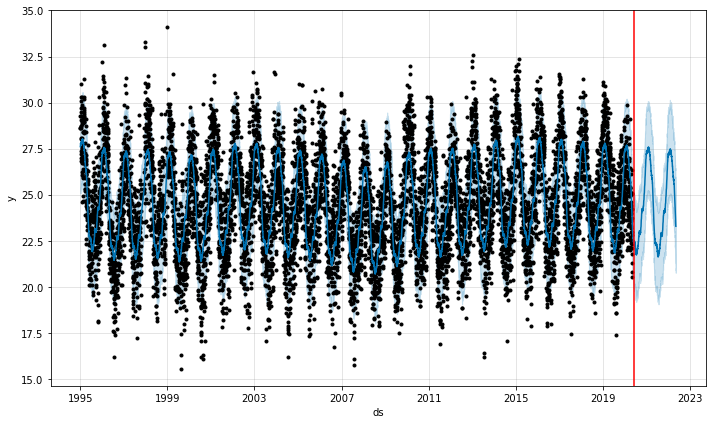

In [45]:
fig1 = m.plot(forecast)
plt.axvline(x= datetime.date(2020,6,1), color='red')


### São Paulo: Previsão para 2 anos

Como o código é o mesmo, o colocarei todo em uma celula

In [46]:
n4 = n4[['Date', 'TempCelcius']]
n4.columns = ['ds','y']
m = Prophet(daily_seasonality=True)
m.fit(n4)
future = m.make_future_dataframe(periods=730)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
9899,2022-05-09,18.428532,14.608365,21.933750
9900,2022-05-10,18.401922,15.001652,21.711189
9901,2022-05-11,18.347852,14.592082,21.875280
9902,2022-05-12,18.294980,15.051117,21.696808
9903,2022-05-13,18.185064,14.850248,21.772391


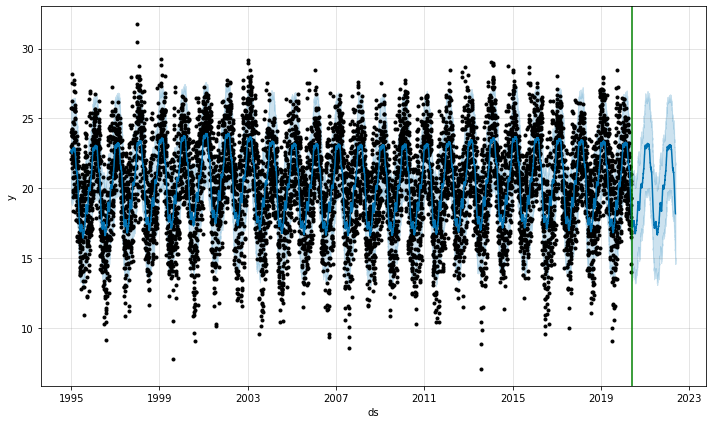

In [47]:
fig1 = m.plot(forecast)
plt.axvline(x= datetime.date(2020,6,1), color='green')

### Brasilia: Previsão para 2 anos

In [48]:
n5 = n5[['Date', 'TempCelcius']]
n5.columns = ['ds','y']
m = Prophet(daily_seasonality=True)
m.fit(n5)
future = m.make_future_dataframe(periods=730)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
9931,2022-05-09,21.799409,19.674710,23.860916
9932,2022-05-10,21.723115,19.663684,23.717931
9933,2022-05-11,21.697229,19.733583,23.692942
9934,2022-05-12,21.642366,19.573596,23.762811
9935,2022-05-13,21.628187,19.658229,23.660805


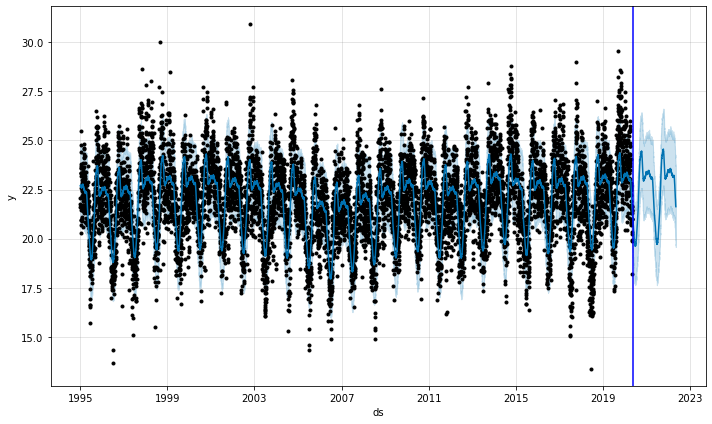

In [49]:
fig1 = m.plot(forecast)
plt.axvline(x= datetime.date(2020,6,1), color='blue')